# Supplementary figure 6

This notebook contains the functions used to construct the supplementary figure 6 in the paper. 

The figure represents the heatmaps (across tumors) with the 96 trinucleotide frequencies. 
Find more details in the **Clusters of somatic mutation processes** section.


In [2]:
%matplotlib inline

from os import path
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import product
from bgreference import hg19

import seaborn.apionly as sns
sns.set_style("whitegrid")
sns.set(font="monospace")

### Data not provided

The input mutation files are not included. There is more information about them in the ``README`` file located in the **non_provided_data** folder.

- mutations_folder: base directory where the files with the mutations. It is expected to have one file named the same as the tumor type and with the extension ``.tsv.gz``

### Other


- *tumor_types_list*: list of tumor types to be analysed.  

In [3]:
# Data not provided
mutation_folder = 'non_provided_data/mutations/'

# Other
tumor_types_list = ['crc', 'ucec', 'bMMRD', 'skcm', 'luad', 'lusc', 'brca', 'blca']

In [4]:
comp_dict = {'A':'T', 'T':'A', 'C':'G', 'G':'C'}

def rev_comp(seq):
    """Compute reverse complement of a sequence"""
    return ''.join([comp_dict[base] for base in seq[::-1]])

# DataFrame with the 96 triplets ordered
triplets = []
for triplet in product('ACTG', repeat=3):
    if triplet[1] not in ['C', 'T']:
        continue
    else:
        for n in 'ACTG':
            if n != triplet[1]:
                triplets.append([''.join(triplet), triplet[1], n])
triplets_96_df = pd.DataFrame(triplets, columns=['tri', 'ref', 'alt'])
triplets_96_df.sort_values(['ref', 'alt', 'tri'], inplace=True)
triplets_96 = pd.DataFrame(triplets_96_df['tri'] + '>' + triplets_96_df['tri'].str[0] + triplets_96_df['alt'] +triplets_96_df['tri'].str[2], columns=['triplets']).reset_index(drop=True)


def compute(sample_g):
    """Prepare the 96 triplets with the normalized values"""
    s = triplets_96.merge(sample_g, how='left')
    s.fillna(0.0, inplace=True)    
    s['sum'] = s['sum']/s['sum'].sum()    
    s.set_index('triplets', inplace=True)
    return s['sum']

In [ ]:
for tumor_type in tumor_types_list:
    print(tumor_type)
    # read mutation data
    mutations_file = path.join(mutation_folder, tumor_type + '.bed.gz')
    mutations_df = pd.read_csv(mutations_file, sep='\t', header=None, low_memory=False)
    mutations_df.columns = ['chr', 'start', 'end', 'ref', 'alt', 'sample', 'type'] 
    # TODO exclude chrM?
    mutations_df = mutations_df[mutations_df['chr']!='chrM']
    mutations_df['tri'] = mutations_df.apply(lambda x: hg19(x['chr'], x['start'], 3), axis=1)
    # get counts of each alteration taking the context
    counts_df = mutations_df.groupby(['sample', 'tri', 'ref', 'alt']).size().reset_index()
    counts_df = counts_df[counts_df['tri'].str.contains("N") == False]  # remove entries with N nucleotide
    
    # Divide in triplets with the "right" nucleotide and "reversed" one
    CT_df = counts_df[counts_df['ref'].isin(['C', 'T'])]
    # Get the reverse complement (to use the 96 signature)
    AG_df = counts_df[~counts_df['ref'].isin(['C', 'T'])].copy()
    AG_df['ref'] = AG_df['ref'].map(comp_dict)
    AG_df['alt'] = AG_df['alt'].map(comp_dict)
    AG_df['tri'] = AG_df['tri'].apply(rev_comp)
    # Merge back to sum the counts of each alteration with context and the corresponding of the rev complement
    mergedf = CT_df.merge(AG_df, on=['sample', 'tri', 'alt', 'ref'], how='outer')
    mergedf.fillna(0, inplace=True)
    mergedf['sum'] = mergedf['0_x'] + mergedf['0_y']
    mergedf['triplets'] = mergedf['tri'] + '>' + mergedf['tri'].str[0] + mergedf['alt'] + mergedf['tri'].str[2]
    mergedf.drop(['0_x', '0_y', 'tri', 'ref', 'alt'], axis=1, inplace=True)
    result = mergedf.groupby('sample').apply(compute)

    result.to_csv(path.join('results', "%s_heatmap_data.txt" % tumor_type), sep='\t', index=True, header=True)

In [5]:
sns.set(font="monospace", font_scale=0.5)

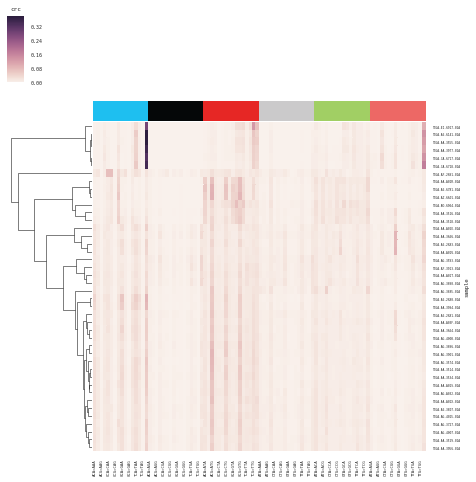

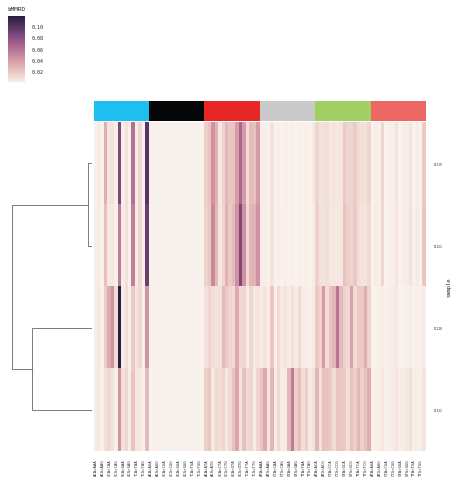

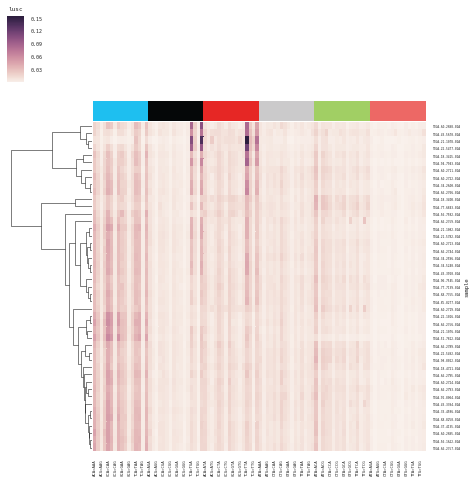

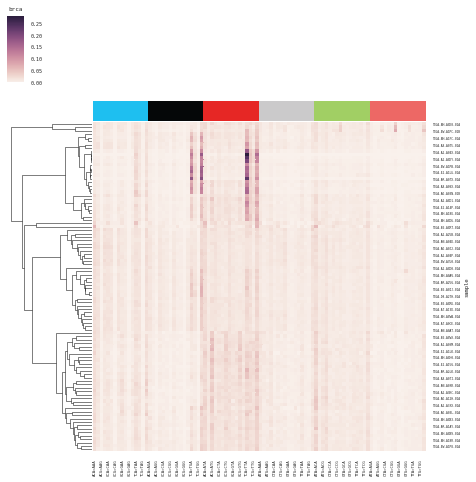

In [21]:
mutType_colors=[]
for col in ['#1EBFF0', '#050708', '#E62725', '#CBCACB', '#A1CF64', '#ED6865']:
    for i in range(0, 16):
        mutType_colors.append(col)
        
colormap = sns.cubehelix_palette(light=.95, as_cmap=True)#sns.cubehelix_palette(8)

for ctype in tumor_types_list:
    filename=path.join('results', "%s_heatmap_data.txt" % ctype)
    tri = pd.read_csv(filename, sep="\t", header=0, index_col=0)
    cg = sns.clustermap(tri, metric="correlation", col_cluster=False, figsize=(7.5, 8),
                        col_colors=mutType_colors, cmap=colormap)
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, fontsize=3)
    plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), fontsize=4)
    plt.title(ctype)
    plt.savefig(path.join('figures', "figureS6_%s.png" % ctype), dpi=500, bbox_inches='tight')
    plt.show()